### The purpose of the work is to classify three different situations in the way people communicate with each other. The first is Spontaneous (autonomous) situation in which two people move their hands freely in front of each other. The second is a synchronous movement in which the two people move their hands together and the third is a movement in position Own. Where only one side moves the hands.
#### The idea is to look at the patterns of the hands and try to deduce from them whether it is a situation alone, spontaneous or synchronous.

In [8]:
# Imports
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

#for data cleaning- organizing
import glob

In [2]:
warnings.filterwarnings("ignore")

def dfbuilder(files):
    final=pd.DataFrame(columns=['Time_x', 'Experiment_x', ' Hand Type_x', ' # hands_x', ' Position X_x',
       ' Position Y_x', ' Position Z_x', ' Velocity X_x', ' Velocity Y_x',
       ' Velocity Z_x', ' Pitch_x', ' Roll_x', ' Yaw_x', ' Wrist Pos X_x',
       ' Wrist Pos Y_x', ' Wrist Pos Z_x', ' Elbow pos X_x', ' Elbow Pos Y_x',
       ' Elbow Pos Z_x', ' Grab Strenth_x', ' Grab Angle_x',' Pinch Strength_x', 
       'Time_y', 'Experiment_y',
       ' Hand Type_y', ' # hands_y', ' Position X_y', ' Position Y_y',
       ' Position Z_y', ' Velocity X_y', ' Velocity Y_y', ' Velocity Z_y',
       ' Pitch_y', ' Roll_y', ' Yaw_y', ' Wrist Pos X_y', ' Wrist Pos Y_y',
       ' Wrist Pos Z_y', ' Elbow pos X_y', ' Elbow Pos Y_y', ' Elbow Pos Z_y',
       ' Grab Strenth_y', ' Grab Angle_y', ' Pinch Strength_y'])
    for file in files:
        temp=pd.read_csv(file)
        #temp=temp.ix[700:]
        temp[" Hand Type"]=Series([1 if i=="right" else 2 for i in temp[" Hand Type"]])
        if str.__contains__(file,"Alone"):  
            temp.insert(loc=1, column='Experiment', value="1")
            temp=temp.drop(' Frame ID',axis=1)
            Handright=pd.read_csv('HandRight.csv')
            Handright[" Hand Type"]=Series([1 if i=="right" else 2 for i in Handright[" Hand Type"]])
            Handright.insert(loc=1, column='Experiment', value="1")
            Handright = Handright.iloc[:len(temp)-1]
            Handright = Handright.reset_index(drop=True)
            Handright=Handright.drop(' Frame ID',axis=1)
            temp = temp.reset_index(drop=True)
            temp = pd.merge(temp, Handright, left_index=True, right_index=True)
        else:
            if str.__contains__(file,"Sync"):
                temp.insert(loc=1, column='Experiment', value="2")
            if str.__contains__(file,"Spontan"):
                temp.insert(loc=1, column='Experiment', value="3") 
            dfright=temp[temp[" Hand Type"]==1]
            dfleft=temp[temp[" Hand Type"]==2]
            dfright.set_index(' Frame ID',inplace=True)
            dfleft.set_index(' Frame ID',inplace=True)
            temp=pd.merge(dfleft, dfright, how='left',on=' Frame ID') 
        final=pd.concat([final,temp])
        
    final=final.drop(["Experiment_y"],axis=1) 
    final=final.dropna()
    final[final.index%20==2]
    final.sort_index(inplace=True)
    return final

In [3]:
test= dfbuilder(glob.glob('Validation/**/*.csv', recursive=True))
train= dfbuilder(glob.glob('Training/**/*.csv', recursive=True))
#train=train.sort_values(by=['Frame ID_x'])
train.head()

,Time_x,Experiment_x,Hand Type_x,# hands_x,Position X_x,Position Y_x,Position Z_x,Velocity X_x,Velocity Y_x,Velocity Z_x,...,Yaw_y,Wrist Pos X_y,Wrist Pos Y_y,Wrist Pos Z_y,Elbow pos X_y,Elbow Pos Y_y,Elbow Pos Z_y,Grab Strenth_y,Grab Angle_y,Pinch Strength_y
0,149.3688,1,2,1,-145.56540,213.8241,19.58267,330.670300,-439.522000,4.798805,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,386.9574,1,2,1,-158.61700,287.6174,-24.87604,-31.299000,356.570400,107.265800,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,580.1392,1,2,1,-108.30850,195.5176,113.37180,-3.592897,5.759355,-23.664740,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,186.3372,1,2,1,-157.43730,204.2224,78.61425,-24.941330,25.784400,-1.884803,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0
0,457.7846,1,2,1,-11.90731,258.5077,37.91010,34.505080,-168.363800,90.208110,...,-0.2778,46.88831,207.3548,86.23589,203.8337,49.33507,237.4553,0.0,0.206389,0.0


In [6]:
test.shape

(53372, 43)

In [7]:
train.shape

(194765, 43)

In [4]:
# Let's simplify the data with groupby
train = train.groupby(np.arange(len(train.index))//200, axis=0).max()
test = test.groupby(np.arange(len(test.index))//200, axis=0).max()

In [5]:
print(train.shape)
print(test.shape)

(974, 43)
(267, 43)


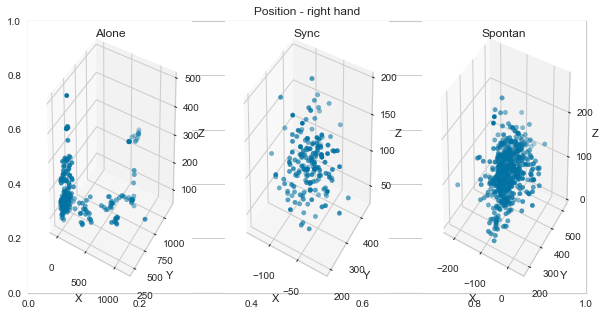

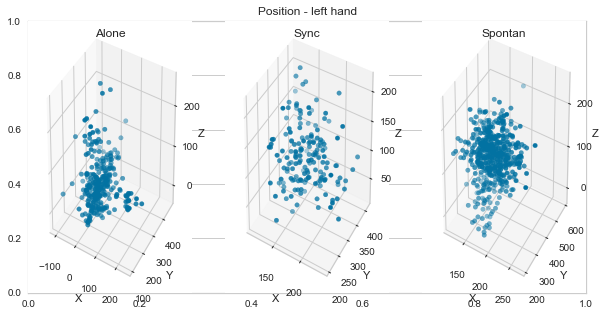

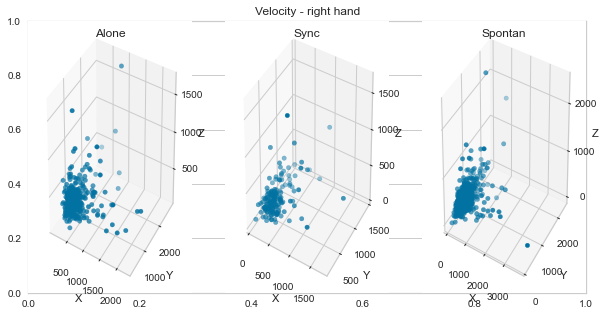

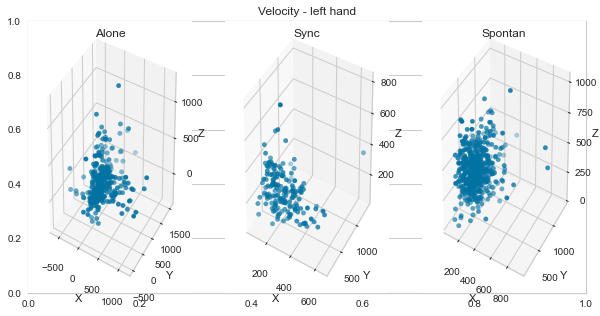

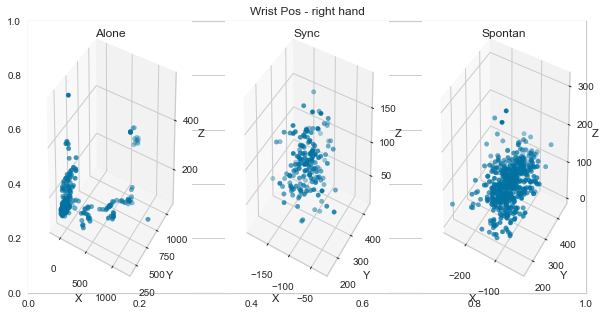

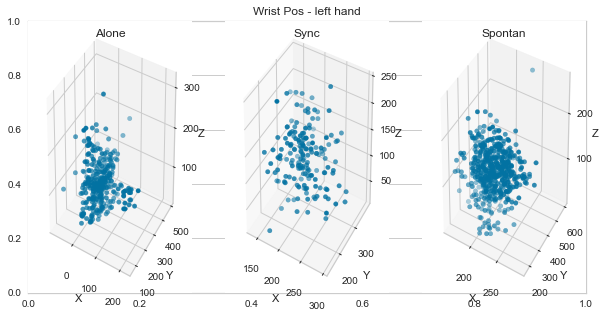

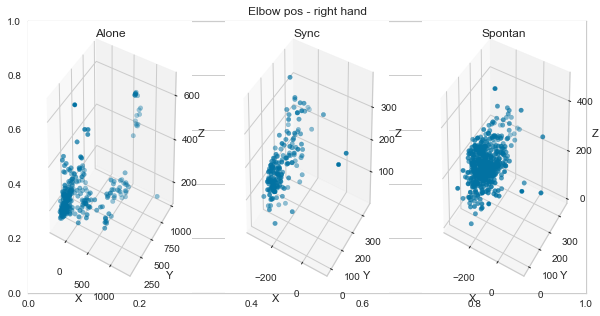

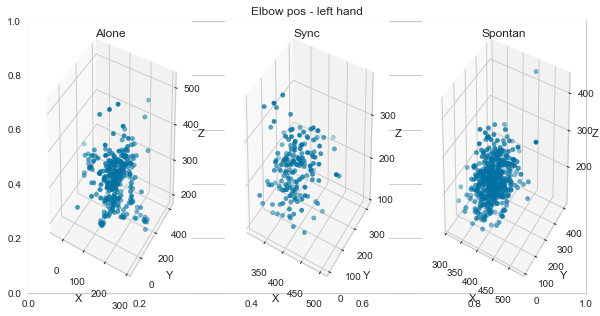

In [60]:
from mpl_toolkits.mplot3d import Axes3D
for pose in ["Position", "Velocity", "Wrist Pos"]:
    fig = plt.figure(figsize=(10,5))
    plt.title(pose+" - right hand")
    for i in range(1,4):
        ax = fig.add_subplot(1,3,i, projection='3d')
        x = train[train['Experiment_x']==str(i)][" "+pose+" X_x"]
        y = train[train['Experiment_x']==str(i)][" "+pose+" Y_x"]
        z = train[train['Experiment_x']==str(i)][" "+pose+" Z_x"]
        ax.scatter(x, y, z,)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        if(i==1):
            plt.title("Alone")
        else:
            if(i==2):
                plt.title("Sync")
            else:
                plt.title("Spontan")
        
    fig = plt.figure(figsize=(10,5))
    plt.title(pose+" - left hand")   
    for i in range(1,4):   
        ax = fig.add_subplot(1,3,i, projection='3d')
        x = train[train['Experiment_x']==str(i)][" "+pose+" X_y"]
        y = train[train['Experiment_x']==str(i)][" "+pose+" Y_y"]
        z = train[train['Experiment_x']==str(i)][" "+pose+" Z_y"]
        ax.scatter(x, y, z,)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        if(i==1):
            plt.title("Alone")
        else:
            if(i==2):
                plt.title("Sync")
            else:
                plt.title("Spontan")

fig = plt.figure(figsize=(10,5))
plt.title("Elbow pos - right hand")
for i in range(1,4):   
    ax = fig.add_subplot(1,3,i, projection='3d')
    x = train[train['Experiment_x']==str(i)][" Elbow pos X_x"]
    y = train[train['Experiment_x']==str(i)][" Elbow Pos Y_x"]
    z = train[train['Experiment_x']==str(i)][" Elbow Pos Z_x"]
    ax.scatter(x, y, z,)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if(i==1):
        plt.title("Alone")
    else:
        if(i==2):
            plt.title("Sync")
        else:
            plt.title("Spontan")
        
fig = plt.figure(figsize=(10,5))
plt.title("Elbow pos - left hand")   
for i in range(1,4):   
    ax = fig.add_subplot(1,3,i, projection='3d')
    x = train[train['Experiment_x']==str(i)][" Elbow pos X_y"]
    y = train[train['Experiment_x']==str(i)][" Elbow Pos Y_y"]
    z = train[train['Experiment_x']==str(i)][" Elbow Pos Z_y"]
    ax.scatter(x, y, z,)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    if(i==1):
        plt.title("Alone")
    else:
        if(i==2):
            plt.title("Sync")
        else:
            plt.title("Spontan")
plt.show()

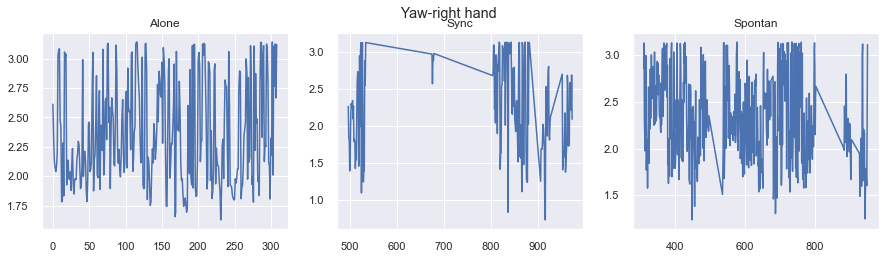

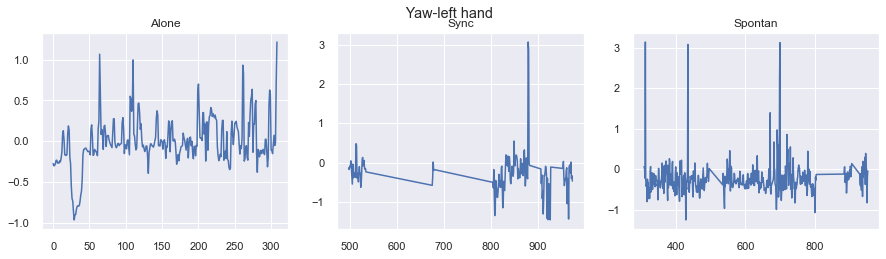

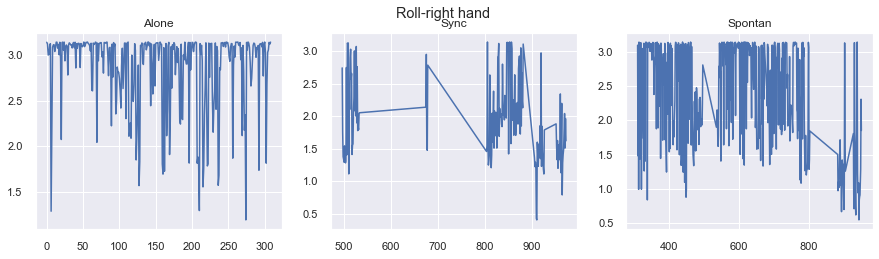

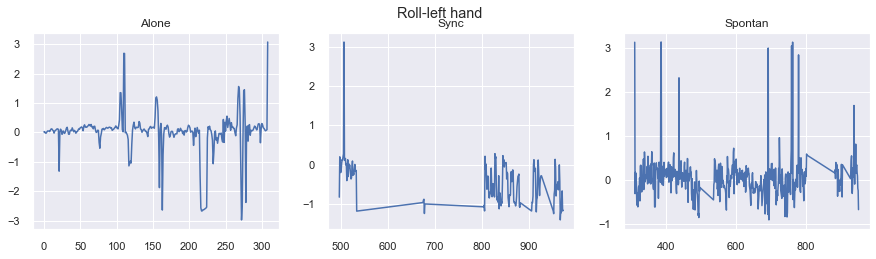

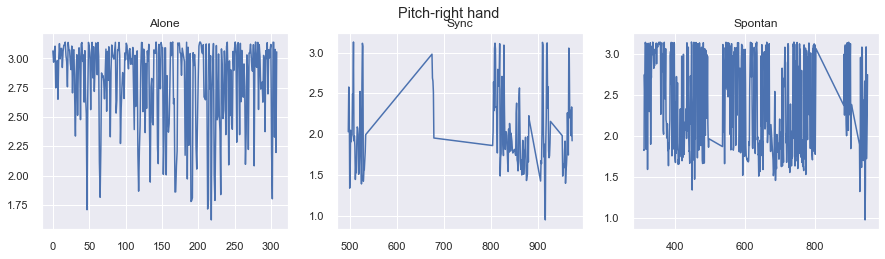

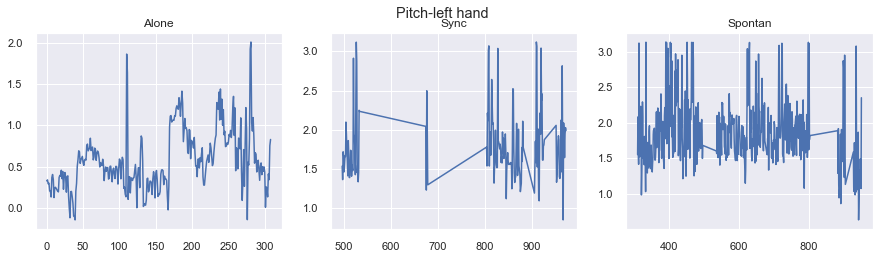

In [61]:
import seaborn as sns
sns.set()
#train.sort_index(inplace=True)
for move in [" Yaw"," Roll"," Pitch"]:
    fig=plt.figure(figsize=(15,3.6))
    fig.suptitle(move+"-right hand")    
    for i in range(1,4):
        plt.subplot(1,3,i)
        train[train['Experiment_x']==str(i)][move+'_x'].plot()
        if(i==1):
            plt.title("Alone")
        else:
            if(i==2):
                plt.title("Sync")
            else:
                plt.title("Spontan")
       
    fig=plt.figure(figsize=(15,3.6))
    fig.suptitle(move+"-left hand")    
    for i in range(1,4):
        plt.subplot(1,3,i)
        train[train['Experiment_x']==str(i)][move+'_y'].plot()
        if(i==1):
            plt.title("Alone")
        else:
            if(i==2):
                plt.title("Sync")
            else:
                plt.title("Spontan")

1 = Alone
2 = Sync
3 = Spontan


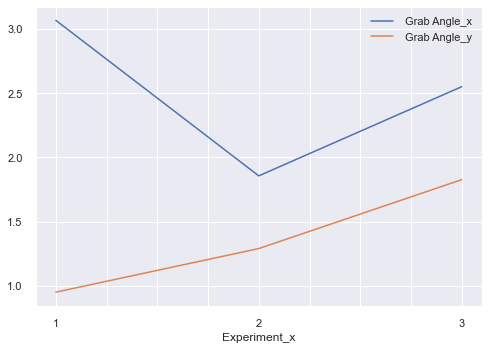

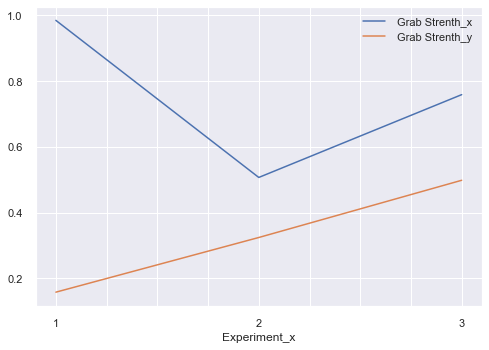

In [62]:
train.groupby(['Experiment_x'])[' Grab Angle_x',' Grab Angle_y'].mean().plot()
train.groupby(['Experiment_x'])[' Grab Strenth_x',' Grab Strenth_y'].mean().plot()
print("1 = Alone")
print("2 = Sync")
print("3 = Spontan")

## Split the data

In [6]:
X_train=train.drop(['Experiment_x'], axis = 1)
y_train=train['Experiment_x']
X_test=test.drop(['Experiment_x'], axis = 1)
y_test=test['Experiment_x']
print("Training FeatureSet:", X_train.shape)
print("Training Labels:", y_train.shape)
print("Testing FeatureSet:", X_test.shape)
print("Testing Labels:", y_test.shape)

Training FeatureSet: (974, 42)
Training Labels: (974,)
Testing FeatureSet: (267, 42)
Testing Labels: (267,)


In [16]:
#normalize- pipline and pca for dimension reduction
pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('reduce_dim', PCA(n_components=16))])
X_reduced_train = pipe.fit_transform(X_train)
X_reduced_test = pipe.transform(X_test)

pd.DataFrame(data=X_reduced_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,8.032700,1.416782,-2.182991,-5.011767,0.186549,-3.158454,3.656825,7.192852,0.382103,3.564312,-0.342485,-0.252390,-1.297430,-0.400475,-0.327142,1.988627
1,4.039997,-2.413557,-0.045906,0.698119,0.740492,-0.973966,-0.704519,0.357357,0.088221,0.157614,-0.234450,-1.184515,0.489778,-1.052158,-0.041888,0.496342
2,4.056811,-2.378656,0.175372,0.544477,1.009443,-0.847780,-1.028276,0.270110,-0.250360,0.252125,-0.362334,-0.936988,-0.053511,0.129503,0.090324,0.547977
3,4.966846,-0.975179,0.267089,0.454771,1.649580,-0.931619,-1.125296,0.640690,0.228486,0.862233,-0.647603,-0.350011,-0.028610,0.106528,0.070090,0.481162
4,4.502741,-1.839791,0.444692,0.916674,1.246064,-0.701464,-0.880802,0.492200,-0.549328,0.759147,-0.075890,-0.595834,0.525689,-0.585348,0.345375,1.227943


In [24]:
#Normalize the train data:
tmp=X_train.values
min_max_scaler=MinMaxScaler()
scaled=min_max_scaler.fit_transform(tmp)
X_train=pd.DataFrame(scaled)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.792387,0.0,0.0,0.153935,0.231764,1.000000,0.088726,0.208435,0.623806,0.965191,...,0.259724,0.343935,0.265631,0.234386,0.431611,0.290947,0.314431,0.0,0.248237,0.000000
1,0.792970,0.0,0.0,0.151555,0.233069,0.211815,0.078791,0.265008,0.139440,0.921669,...,0.253764,0.344492,0.266182,0.234434,0.439715,0.296310,0.318574,0.0,0.264695,0.194288
2,0.793511,0.0,0.0,0.151454,0.171334,0.215542,0.154594,0.156152,0.135260,0.963043,...,0.254502,0.340296,0.280096,0.245322,0.449952,0.317109,0.310282,0.0,0.172750,0.000000
3,0.794052,0.0,0.0,0.268123,0.175430,0.229615,0.178054,0.248324,0.185023,0.983936,...,0.258798,0.332978,0.328878,0.233512,0.451558,0.379533,0.305116,0.0,0.036121,0.000000
4,0.794633,0.0,0.0,0.231780,0.127633,0.253376,0.098425,0.258161,0.106836,0.821340,...,0.267946,0.311486,0.307737,0.117565,0.418286,0.388204,0.286100,0.0,0.059705,0.000000


In [25]:
#Normalize the test data:
tmp=X_test.values
min_max_scaler=MinMaxScaler()
scaled=min_max_scaler.fit_transform(tmp)
X_test=pd.DataFrame(scaled)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,0.927662,0.0,0.0,0.083967,0.240984,0.330971,0.073331,0.407534,0.110133,0.950067,...,0.232732,0.116019,0.325422,0.228019,0.341410,0.171403,0.351074,0.0,0.255818,0.194288
1,0.928348,0.0,0.0,0.163431,0.260338,0.556923,0.171622,0.118732,0.380278,0.890298,...,0.241973,0.123099,0.388659,0.338078,0.386043,0.257667,0.421779,0.0,0.102431,0.000000
2,0.929035,0.0,0.0,0.197186,0.448147,0.551939,0.116637,0.254354,0.336790,0.512823,...,0.235850,0.139888,0.587319,0.341843,0.391306,0.440725,0.458374,0.0,0.177920,0.000000
3,0.929722,0.0,1.0,0.301978,0.416682,0.969126,0.090065,0.198594,0.188344,0.448573,...,0.247581,0.120484,0.421686,0.217289,0.363783,0.270316,0.419356,0.0,0.179644,0.000000
4,0.930408,0.0,1.0,0.293896,0.421759,0.927126,0.312899,0.305364,0.343405,0.464962,...,0.323360,0.485692,0.358063,0.273354,0.395310,0.233480,0.559582,0.0,0.197627,0.000000


## feature-selection 

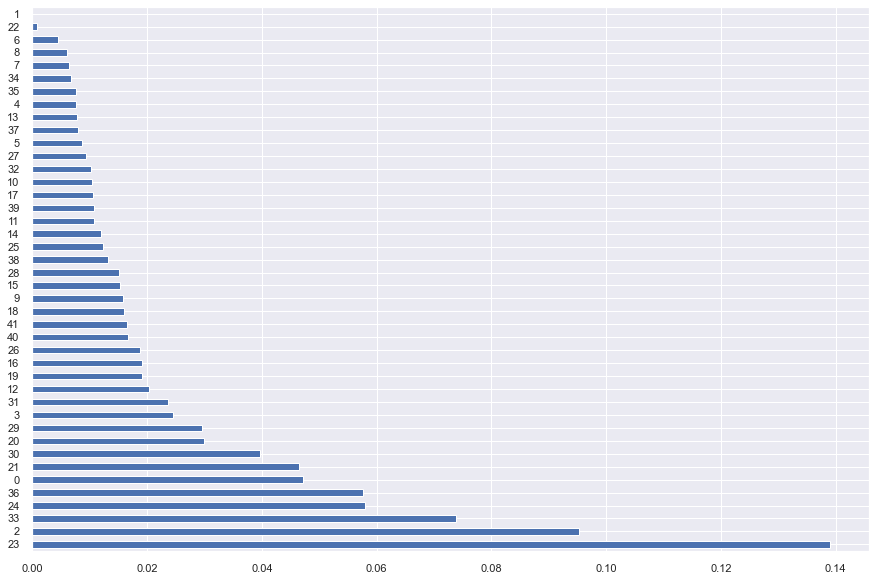

In [66]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(X_train,y_train)
model.feature_importances_ #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
plt.figure(figsize=(15,10))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(42).plot(kind='barh')
plt.show()

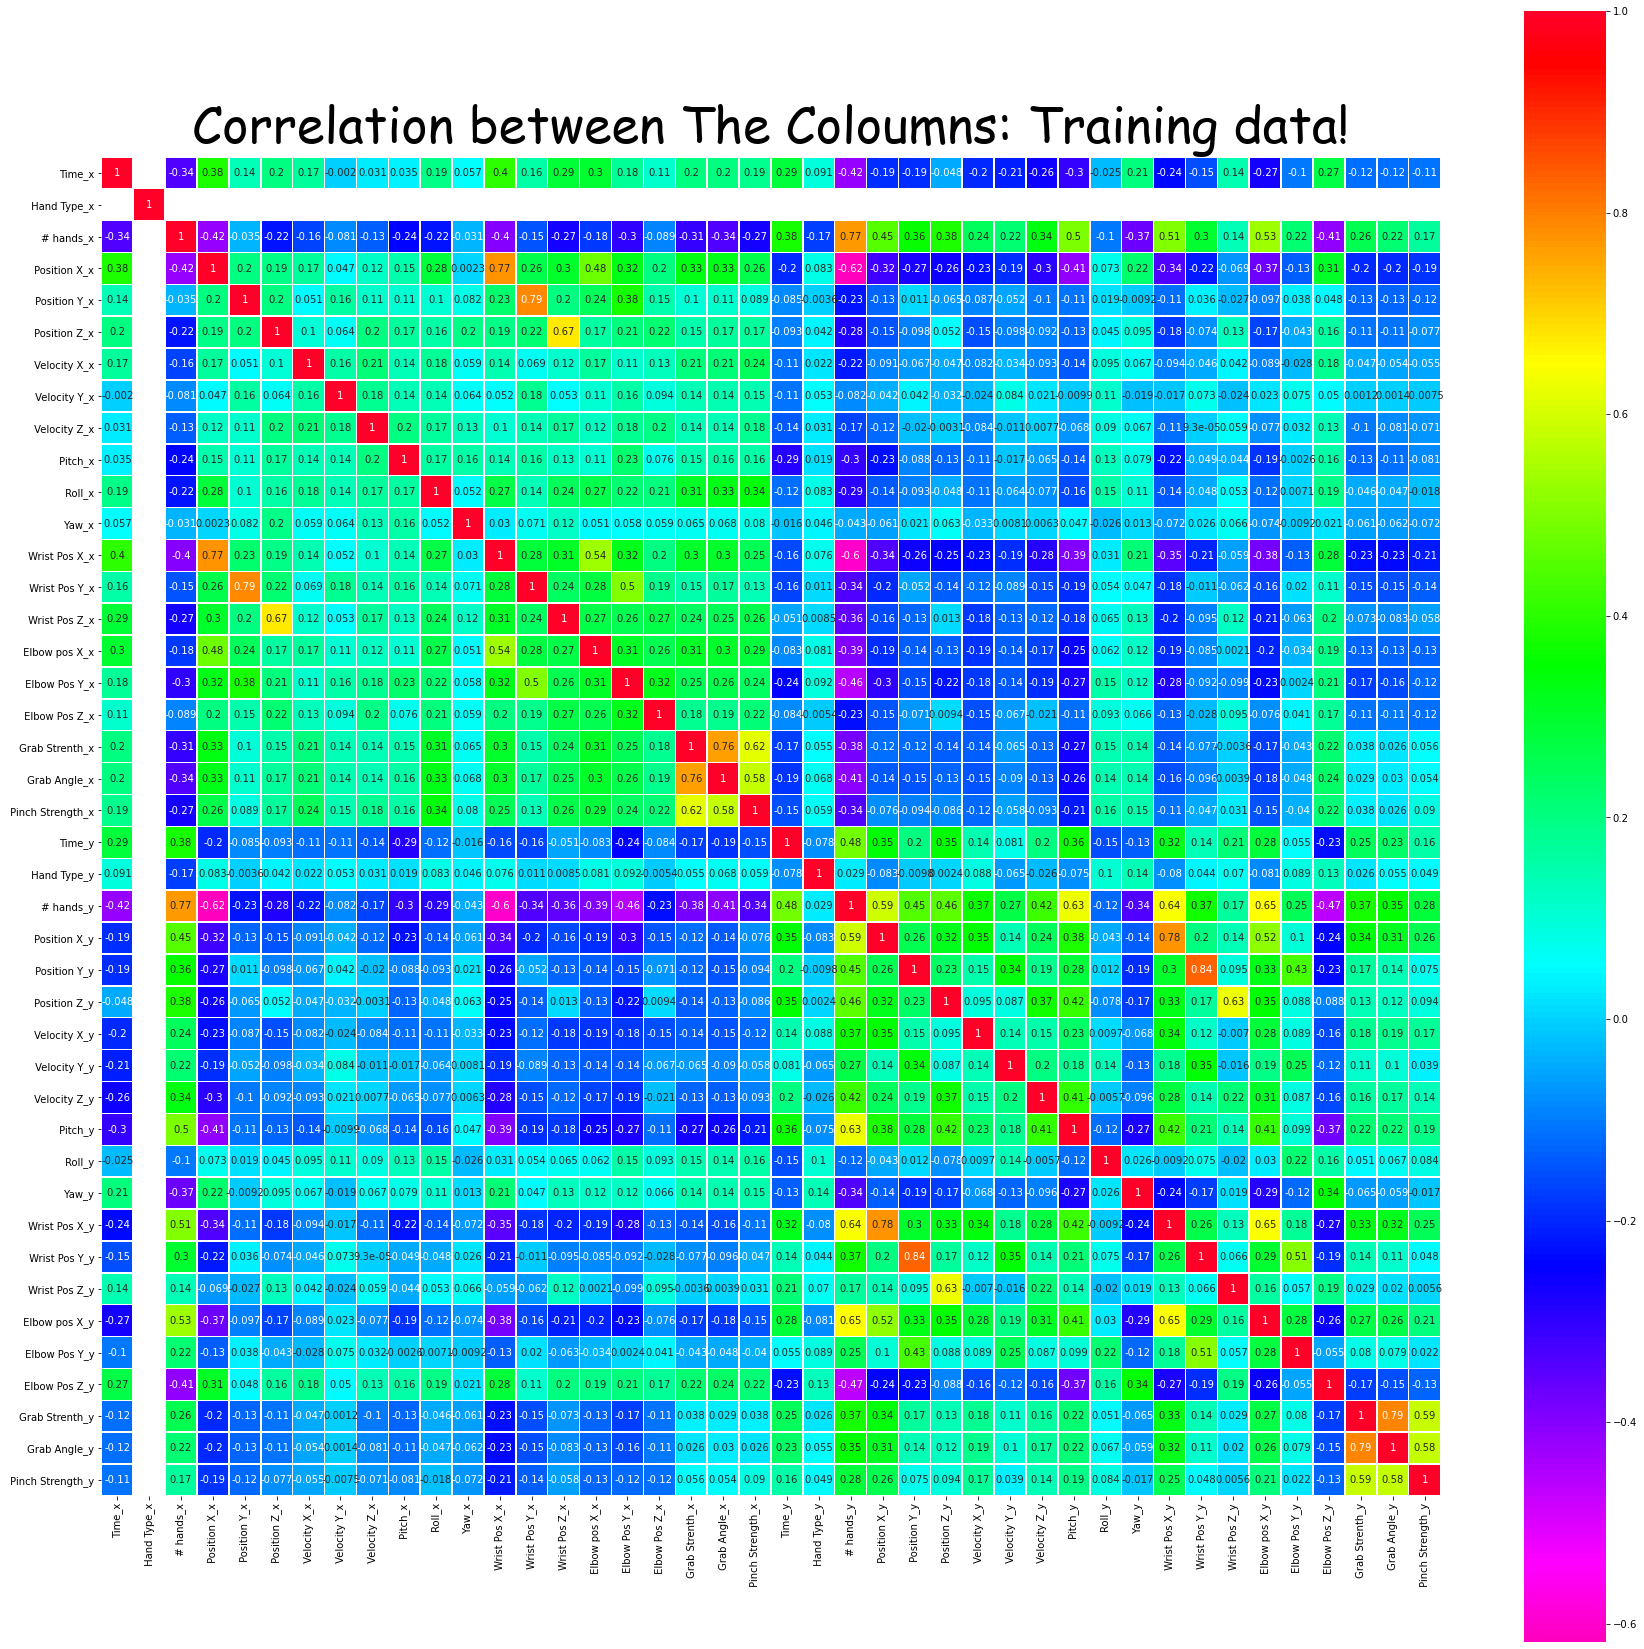

In [65]:
import seaborn as sns
csfont = {'fontname':'Comic Sans MS'}
#get correlations of each features in dataset
plt.figure(figsize=(30,30))
axes=sns.heatmap(train.corr(method ='kendall'),annot=True,square=True,cmap="gist_rainbow_r", linewidths=.5)
axes.set_title("Correlation between The Coloumns: Training data!",**csfont,fontsize=50)

plt.show()

In [57]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, StackingClassifier,VotingClassifier
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import time

## KNN

In [26]:
k_time=time.time()
k_range = list(range(1, 20))
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_reduced_train, y_train)
    y_pred = knn.predict(X_reduced_test)
    scores.append(metrics.accuracy_score(y_test, y_pred))
print(scores)
TimeTaken=time.time() -k_time
print("Time taken to achive result: %s seconds" % (TimeTaken))

[0.8202247191011236, 0.7940074906367042, 0.8314606741573034, 0.8164794007490637, 0.8314606741573034, 0.8089887640449438, 0.8389513108614233, 0.8314606741573034, 0.846441947565543, 0.8389513108614233, 0.850187265917603, 0.8539325842696629, 0.8689138576779026, 0.8614232209737828, 0.8651685393258427, 0.8614232209737828, 0.8801498127340824, 0.8651685393258427, 0.8838951310861424]
Time taken to achive result: 0.3011007308959961 seconds


Text(0, 0.5, 'Testing Accuracy')

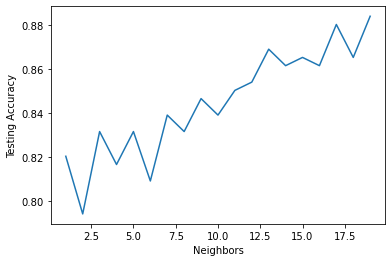

In [27]:
# the connection between K and testing accuracy
plt.plot(k_range, scores)
plt.xlabel('Neighbors')
plt.ylabel('Testing Accuracy')

#### the best k is k=17

Confusion Matrix for KNN


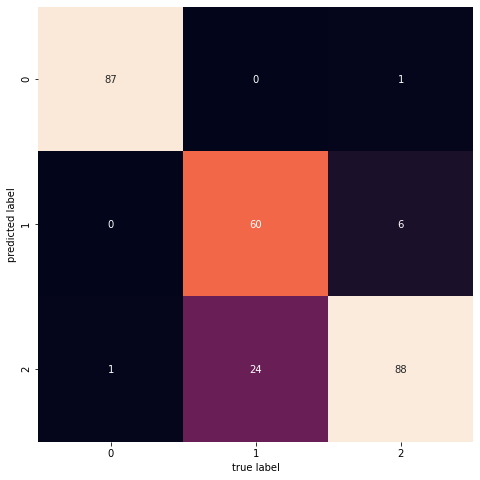

              precision    recall  f1-score   support

           1       0.99      0.99      0.99        88
           2       0.91      0.71      0.80        84
           3       0.78      0.93      0.85        95

    accuracy                           0.88       267
   macro avg       0.89      0.88      0.88       267
weighted avg       0.89      0.88      0.88       267

This KNN model's Accuracy Score with cross validation is  [0.85128205 0.87179487 0.89230769 0.89230769 0.85051546]
This KNN model's Accuracy mean Score with cross validation is  0.8716415543219667
Accuracy: 0.8801498127340824
Time taken to achive result: 0.2155294418334961 seconds


In [28]:
# knn with 16 dimention of pca
knnStartTime=time.time()
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_reduced_train, y_train)
y_pred=knn.predict(X_reduced_test)
plt.figure(1, figsize= (8,8))
cm=confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print("Confusion Matrix for KNN")
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
plt.close() 
print(classification_report(y_test,y_pred))
score= cross_val_score(knn, X_reduced_train, y_train, cv=5,scoring='accuracy')
print("This KNN model's Accuracy Score with cross validation is ", score)
print("This KNN model's Accuracy mean Score with cross validation is ",score.mean())
y_pred=knn.predict(X_reduced_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
knnTimeTaken=time.time() -knnStartTime
print("Time taken to achive result: %s seconds" % (knnTimeTaken))

## K Means

              precision    recall  f1-score   support

           1       0.99      0.99      0.99        88
           2       0.91      0.71      0.80        84
           3       0.78      0.93      0.85        95

    accuracy                           0.88       267
   macro avg       0.89      0.88      0.88       267
weighted avg       0.89      0.88      0.88       267

Accuracy: 0.8801498127340824
Confusion Matrix for K means


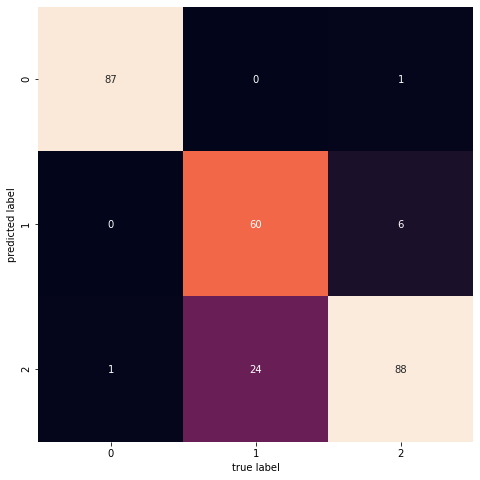

In [30]:
km = KMeans(n_clusters=20, random_state=1,max_iter=100)
km.fit(X_reduced_train, y_train)
y_km= km.predict(X_reduced_test)
print(classification_report(y_test,y_pred))
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
plt.figure(1, figsize= (8,8))
cm=confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print("Confusion Matrix for K means")
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
plt.close() 

## Random Forest

In [35]:
# We will examine what the best parameters are with grid
from sklearn.model_selection import GridSearchCV
param_grid = {
    'bootstrap': [True],
    'max_depth': [5,10,20,30,40,50,60,70,80,90,100,110],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100,150, 200, 250, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
#Fit the grid search to the data
grid_search.fit(X_reduced_train,y_train)
grid_search.best_params_

Fitting 3 folds for each of 1944 candidates, totalling 5832 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 5832 out of 5832 | elapsed: 15.2min finished


{'bootstrap': True,
 'max_depth': 60,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 12,
 'n_estimators': 100}

In [39]:
#use this parameters :
rf_clf=RandomForestClassifier(max_depth= 60, max_features= 2,
                              min_samples_leaf= 3,min_samples_split= 12, n_estimators= 100)
rf_clf.fit(X_reduced_train,y_train)
y_pred=rf_clf.predict(X_reduced_test)
print(classification_report(y_test,y_pred))
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      0.97      0.98        88
           2       0.90      0.67      0.77        84
           3       0.74      0.94      0.83        95

    accuracy                           0.86       267
   macro avg       0.88      0.86      0.86       267
weighted avg       0.88      0.86      0.86       267

Accuracy: 0.8614232209737828


## AdaBoost

In [41]:
# We will examine what the best parameters are with grid
param_grid = {
    'random_state': [0,1,2,3,4,5,10,20,30,40,50,60,70,80,90,100,110],
    'learning_rate': [0, 1, 2, 3, 4],
    'n_estimators': [20,50,80,100,150,200,250,300]
}
# Create a based model
adb = AdaBoostClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = adb, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
#Fit the grid search to the data
grid_search.fit(X_reduced_train,y_train)
grid_search.best_params_

Fitting 3 folds for each of 680 candidates, totalling 2040 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 934 tasks      | elapsed:   42.2s
[Parallel(n_jobs=-1)]: Done 1261 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1544 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1909 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 2040 out of 2040 | elapsed:  2.2min finished


{'learning_rate': 2, 'n_estimators': 100, 'random_state': 1}

In [43]:
adb_clfTime=time.time()
adb_clf = AdaBoostClassifier(n_estimators=100,
                         learning_rate=2, random_state=1)
adb_clf.fit(X_reduced_train, y_train)
y_pred= adb_clf.predict(X_reduced_test)
print(classification_report(y_test,y_pred))
print("Accuracy = {}".format(accuracy_score(y_test, y_pred)))
adb_clfTimeTaken=time.time() -adb_clfTime
print("Time taken to achive result: %s seconds" % (adb_clfTimeTaken))


              precision    recall  f1-score   support

           1       1.00      0.94      0.97        88
           2       0.84      0.70      0.77        84
           3       0.75      0.91      0.82        95

    accuracy                           0.85       267
   macro avg       0.87      0.85      0.85       267
weighted avg       0.86      0.85      0.85       267

Accuracy = 0.8539325842696629
Time taken to achive result: 0.33390355110168457 seconds


## Bagging

In [46]:
# We will examine what the best parameters are with grid
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_samples': [1,2,3],
    'max_features': [1,2,3],
    'random_state': [0,1,2,3,4,5],
    'n_jobs': [0,1,2,3,4,5,8,10,12],
    'n_estimators': [2,3,4,5,10,15,20,25,30,50,10,150,200]
}
# Create a based model
bag = BaggingClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = bag, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
#Fit the grid search to the data
grid_search.fit(X_reduced_train,y_train)
grid_search.best_params_

Fitting 3 folds for each of 6318 candidates, totalling 18954 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 1072 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done 1844 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 2752 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 4061 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 5880 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 7852 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 10312 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 12489 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 14746 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 18290 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 18954 out of 18954 | elapsed:  5.6min finished


{'max_features': 3,
 'max_samples': 3,
 'n_estimators': 50,
 'n_jobs': 1,
 'random_state': 4}

In [50]:
bag_clf =BaggingClassifier(n_estimators=50, max_features= 3, max_samples= 3, n_jobs= 1, random_state=4)
bag_clf.fit(X_train, y_train)
y_pred= bag_clf.predict(X_test)
print(classification_report(y_test,y_pred))
print("Accuracy = {}".format(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

           1       0.94      0.88      0.91        88
           2       0.00      0.00      0.00        84
           3       0.50      0.98      0.66        95

    accuracy                           0.64       267
   macro avg       0.48      0.62      0.52       267
weighted avg       0.49      0.64      0.53       267

Accuracy = 0.6367041198501873


## Voting

In [54]:
# Voting with: AdaBoost, KNN and Random Forest
vot_soft = VotingClassifier(estimators=[('adb',adb_clf),('kn',knn),('rf',rf_clf)], voting ='soft')
vot_soft.fit(X_reduced_train, y_train)
y_pred = vot_soft.predict(X_reduced_test)
print(classification_report(y_test,y_pred))
print("Accuracy = {}".format(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

           1       1.00      0.95      0.98        88
           2       0.95      0.70      0.81        84
           3       0.76      0.97      0.85        95

    accuracy                           0.88       267
   macro avg       0.90      0.88      0.88       267
weighted avg       0.90      0.88      0.88       267

Accuracy = 0.8801498127340824


## Stacking

In [63]:
# Stacking with: Random Forest, Knn
stacking_clf=StackingClassifier(estimators=[('rf',rf_clf),('kn',knn)],final_estimator=LogisticRegression())
stacking_clf.fit(X_reduced_train,y_train)
y_pred= stacking_clf.predict(X_reduced_test)

metrics.accuracy_score(y_test, y_pred)
print(classification_report(y_test,y_pred))
print("Accuracy = {}".format(accuracy_score(y_test, y_pred)))

              precision    recall  f1-score   support

           1       1.00      0.98      0.99        88
           2       0.94      0.71      0.81        84
           3       0.78      0.96      0.86        95

    accuracy                           0.89       267
   macro avg       0.91      0.88      0.89       267
weighted avg       0.90      0.89      0.89       267

Accuracy = 0.8876404494382022


Confusion Matrix for Stacking:


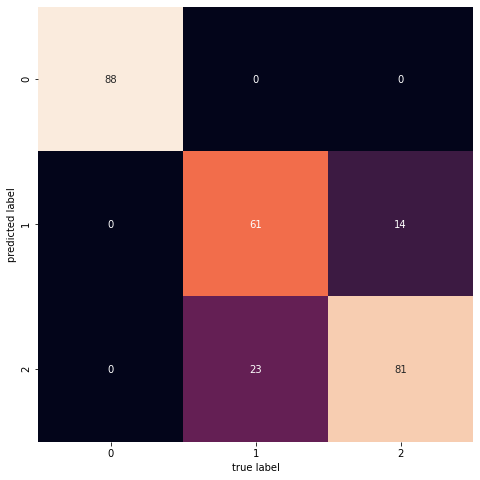

In [67]:
#Confusion Matrix for Stacking
plt.figure(1, figsize= (8,8))
cm=confusion_matrix(y_test, y_pred, labels=None, sample_weight=None)
print("Confusion Matrix for Stacking:")
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()
plt.close() 

## here we got the beat accuracy with Stacking: 88.76%